# Using hover to compare wrfout files

In this chapter, I want to compare different profiles at same place from two different files.

In [1]:
import cmaps
import numpy as np
import xarray as xr
from copy import copy
from xgcm import Grid
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import shapely.geometry as sgeom
import cartopy.feature as cfeature
from xgcm.autogenerate import generate_grid_ds
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

Fix the bug of Lambert (cartopy).

The original link: https://gist.github.com/ajdawson/dd536f786741e987ae4e

In [2]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])

def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

Set the part of hover function.

The original link of question: https://stackoverflow.com/questions/53446684/python-show-corresponding-profile-upon-hovering-clicking-over-a-grid

In [3]:
def plot_profile(ax,fig,id_lat, id_lon,event_lat,event_lon):
    ax.cla()
    if ax == ax3:
        ax.plot(plot_variable[0][:, id_lat, id_lon], pressure[:, id_lat, id_lon])
        ax.set_title("NO2 (with lnox) lon: {:.1f}, lat: {:.1f}".format(event_lat, event_lon))
    elif ax == ax4:
        ax.plot(plot_variable[1][:, id_lat, id_lon], pressure[:, id_lat, id_lon])
        ax.set_title("NO2 (without lnox) lon: {:.1f}, lat: {:.1f}".format(event_lat, event_lon))

    ax.invert_yaxis()
    ax.set_xlabel('pptv')
    ax.set_ylabel('hPa')

def on_move(event):
    '''see https://stackoverflow.com/questions/53446684/
        python-show-corresponding-profile-upon-hovering-clicking-over-a-grid'''
    global current_lat, current_lon
    if event.inaxes is ax1:
        event_lat = event.ydata
        event_lon = event.xdata 
        event_lon,event_lat=ccrs.PlateCarree().transform_point(event.xdata,event.ydata,proj)
        id_lat = np.where(lat==lat[lat<=event_lat][-1])[0][0]
        id_lon = np.where(lon==lon[lon<=event_lon][-1])[0][0]

        # only plot if we have different values than the previous plot
        if id_lat != current_lat or id_lon != current_lon:
            current_lat = id_lat
            current_lon = id_lon
            plot_profile(ax3,fig,id_lat, id_lon,event_lat,event_lon)
            plot_profile(ax4,fig,id_lat, id_lon,event_lat,event_lon)
            fig.canvas.draw_idle()

Let's read files before plotting:

In [4]:
lnox_file   = 'Files/wrfout_lnox_extracted.nc'
nolnox_file = 'Files/wrfout_nolnox_extracted.nc'
lnox   = xr.open_dataset(lnox_file).isel(Time=0)
nolnox = xr.open_dataset(nolnox_file).isel(Time=0)
lnox.rename({'XLONG':'lon','XLAT':'lat'}, inplace=True)

TL         = lnox['CG_FLASHCOUNT'] + lnox['IC_FLASHCOUNT']
pressure   = (lnox['P']+lnox['PB'])/100 # hPa
no2_lnox   = lnox['no2']*1E6 # pptv
no2_nolnox = nolnox['no2']*1E6

Like [Chapter_04](https://github.com/zxdawn/GEOSChem-python-tutorial/blob/master/Chapter04_regridding_WRFChem.ipynb), we need to convert 2D coordinates from cell center to bound for pcolormesh

In [5]:
# Calculate boundary for plotting
# Generate outer dimensions from center input
lnox_post = generate_grid_ds(lnox, {'X':'west_east', 'Y':'south_north'}, position=('center', 'outer'))

# Generate the 2d coordinates for the cell boundaries
# with the "standard" xgcm interpolation for each logical dimension
grid_ds = Grid(lnox_post, periodic=False)
bnd='extrapolate'
lnox_post.coords['lon_b'] = grid_ds.interp(grid_ds.interp(lnox_post['lon'], 'X', boundary=bnd, fill_value=np.nan),
                                          'Y', boundary=bnd, fill_value=np.nan)
lnox_post.coords['lat_b'] = grid_ds.interp(grid_ds.interp(lnox_post['lat'], 'X', boundary=bnd, fill_value=np.nan),
                                          'Y', boundary=bnd, fill_value=np.nan)

Let's plot!

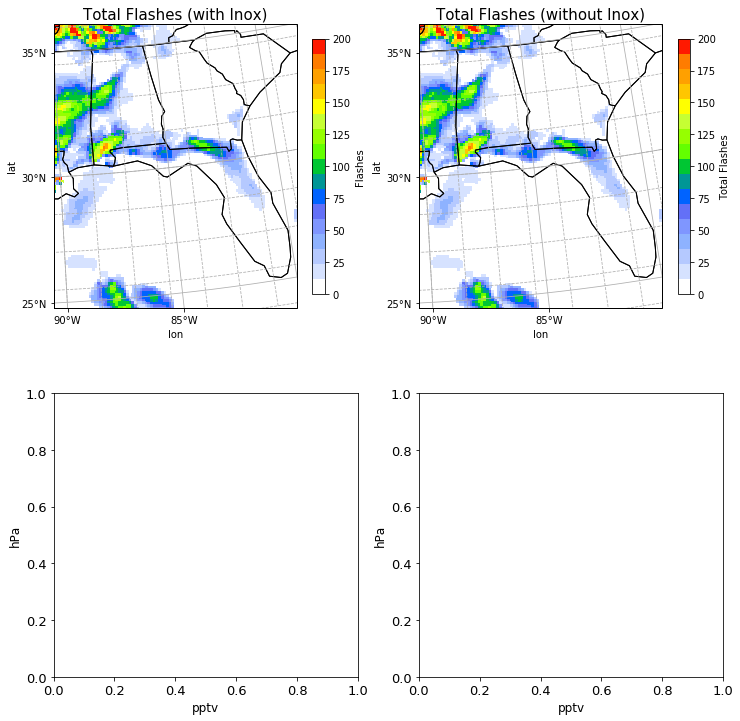

In [6]:
plot_variable = [no2_lnox, no2_nolnox]
proj = ccrs.LambertConformal(central_latitude=39,central_longitude=-95,
                            standard_parallels = (39, 39))

fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace = 0.3)

ax1 = plt.subplot(2,2,1,projection = proj)
ax2 = plt.subplot(2,2,2,projection = proj,sharex=ax1, sharey=ax1)
ax4 = plt.subplot(2,2,4)
ax3 = plt.subplot(2,2,3,sharex=ax4)

m_1 = ax1.pcolormesh(lnox_post['lon_b'], lnox_post['lat_b'], TL, cmap=cmaps.precip3_16lev,transform=ccrs.PlateCarree(),vmin=0, vmax=200)
m_2 = ax2.pcolormesh(lnox_post['lon_b'], lnox_post['lat_b'], TL, cmap=cmaps.precip3_16lev,transform=ccrs.PlateCarree(),vmin=0, vmax=200)
clb_1 = plt.colorbar(m_1,ax=ax1,shrink=0.9)
clb_2 = plt.colorbar(m_2,ax=ax2,shrink=0.9)
clb_1.set_label('Flashes')
clb_2.set_label('Total Flashes')

# Plot labels
xticks = [-100,-95,-90,-85,-80,-75]
yticks = [20, 25, 30, 35,40]
for ax in [ax1,ax2]:
    if ax == ax1:
        ax.set_title('Total Flashes (with lnox)',fontsize = 15)
    elif ax == ax2:
        ax.set_title('Total Flashes (without lnox)',fontsize = 15)
    ax.set_xlabel('lon'); ax.set_ylabel('lat')
    ax.coastlines()
    ax.add_feature(cfeature.STATES)
    ax.gridlines(linestyle='--')
    ax.set_extent([-90, -80, 25, 35], crs=ccrs.PlateCarree())
    # Draw ticks
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks)
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER); ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    lambert_xticks(ax, xticks); lambert_yticks(ax, yticks)

for ax in [ax3,ax4]:
    ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
    ax.set_xlabel('pptv',fontsize=12)
    ax.set_ylabel('hPa',fontsize=12)

# Get 1D lon and lat
lat = lnox['lat'][:,0].values; lon = lnox['lon'][0,:].values
current_lat, curret_lon = None, None
cid = fig.canvas.mpl_connect('button_release_event', on_move)

Since jupyter notebook doesn't support interaction, I plot the GIF below:

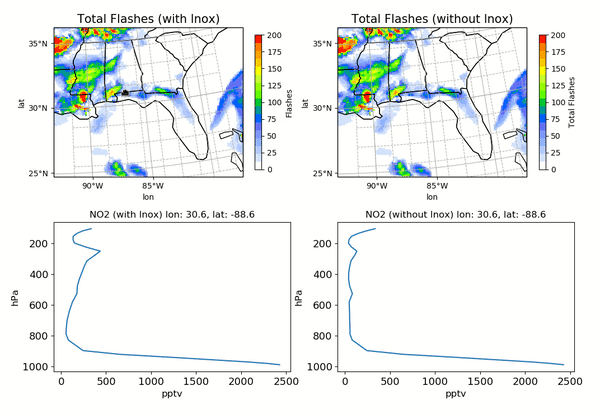

In [7]:
from IPython.display import Image
with open('Files/example.gif','rb') as f:
    display(Image(data=f.read(), format='png'))